In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from dpmm import DirichletProcessMixtureModel, compute_cluster_purity

np.random.seed(410)
plt.style.use('default')
plt.rcParams['figure.figsize'] = (10, 6)

## Dirichlet Process Mixture Models (DPMM)

---

The dpmm.DirichletProcessMixtureModel class implements the DPMM algorithm using Gaussian components with Normal priors. This implementation uses collapsed Gibbs sampling for inference.

## Background

### Dirichlet Process

The Dirichlet distribution $\text{Dir}(\alpha, G_0)$ is a multivariate generalization of the beta distribution. It can be thought of as a distribution of probability vectors $\boldsymbol{p}$ defined by a concentration parameter $\boldsymbol{\alpha} =(\alpha_1, \dots, \alpha_K)$ where $\alpha_k > 0$. The PDF of the Dirichlet distribution is below.

$$
\begin{align*}
\text{Dir}(\boldsymbol{p}|\boldsymbol{\alpha}) = \frac{1}{B(\boldsymbol{\alpha})}\prod_{k=1}^Kp_k^{a_k-1}
\end{align*}$$

Suppose we have some observed data $x = (x_1, \dots, x_n)$ drawn from an unknown generic distribution $p$. A Dirichlet process $\text{DP}(p_0, \alpha)$ can be thought of as a distribution of probability distributions defined by a base distribution $p_0$ (expected value of $p$) and a scalar $\alpha$. Given a Dirichlet process defined over an unordered set of random variables $S$, $n$ number of sample functions drawn from it $f \sim \text{DP}(p_0, \alpha)$ partition $S$ into subsets $B_i$ according to the following:

$$
\begin{align*}
(f(B_1), \dots, f(B_n)) \sim \text{Dir}(\alpha p_0(B_1), \dots, \alpha p_0(B_n))
\end{align*}$$

The Dirichlet process allows us to define priors over $p$, where $\alpha$ is the probability of any given sample to fall into $p_0$. The larger $\alpha$, the closer the drawn distributions are to $p_0$; the smaller $\alpha$, the more likely the drawn distributions are to be discrete with repeated values.

### Dirichlet Process Mixture Model

A Dirichlet process mixture model (DPMM) extends the Dirichlet process for infinite clusters. It can be understood using the Chinese restarant problem which works as follows: After entering a Chinese restaurant, each customer sits at an already occupied table with probability proportional to the number of people already sitting there $n_i$, or at a new table with probability proportional to $\alpha$. 

1. Each data point is modeled as being generated from a mixture component whose parameters are drawn from a distribution that follows a Dirichlet process:

    $$\begin{align}
    p &\sim \text{DP}(\alpha, p_0) \\
    \theta_i &\sim p \\
    x_i &\sim F(\cdot|\theta_i)
    \end{align}$$

    Where $F(\cdot|\theta_i)$ is the likelihood function (in this implementation, a multivariate Gaussian), $\theta_i$ are the parameters for data point $i$, $p_0$ is the base distribution (prior over component parameters), and $\alpha$ is the concentration parameter controlling the diversity of clusters.

2. For multivariate Gaussian components, this implementation uses a Normal-Inverse-Wishart ($\mathcal{W}^{-1}$) prior on the parameters $\theta_i = (\mu_i, \Sigma_i)$:
$$p_0(\mu, \Sigma) = \mathcal{N}(\mu|\mu_0, \Sigma/\kappa_0) \mathcal{W}^{-1}(\Sigma|\Lambda_0, \nu_0)$$

3. We integrate out component parameters and sample cluster assignments $z_i$ using Gibb's sampling:
    1. Initialize by assigning each point to its own cluster
    2. For each $x_i$:
        1. Remove $x_i$ from its current cluster
        2. Compute the probability of $x_i$ belonging to each existing cluster, and to a new cluster using
            $$P(z_i = k | z_{-i}, x_i, X_{-i}) \propto
            \begin{cases}
            n_{k,-i} \cdot f(x_i|\mu_k, \Sigma_k) & \text{if } k \text{ is an existing cluster} \\
            \alpha \cdot p_{\text{pred}}(x_i) & \text{if } k \text{ is a new cluster}
            \end{cases}$$
        3. Sample a new cluster assignment based on these probabilities
        4. Update cluster parameters by computing the posterior NIW parameters given the data in the cluster:
            $$\begin{align*}
            \kappa_n &= \kappa_0 + n_k \\
            \mu_n &= \frac{\kappa_0\mu_0 + n_k\bar{x}_k}{\kappa_0 + n_k} \\
            \nu_n &= \nu_0 + n_k \\
            \Lambda_n &= \Lambda_0 + S_k + \frac{\kappa_0 n_k}{\kappa_0 + n_k}(\bar{x}_k - \mu_0)(\bar{x}_k - \mu_0)^T
            \end{align*}$$


## Example Data Clustering

/var/folders/_m/j48mn9812m961127xq723wmh0000gn/T/ipykernel_37693/3666118131.py:26: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


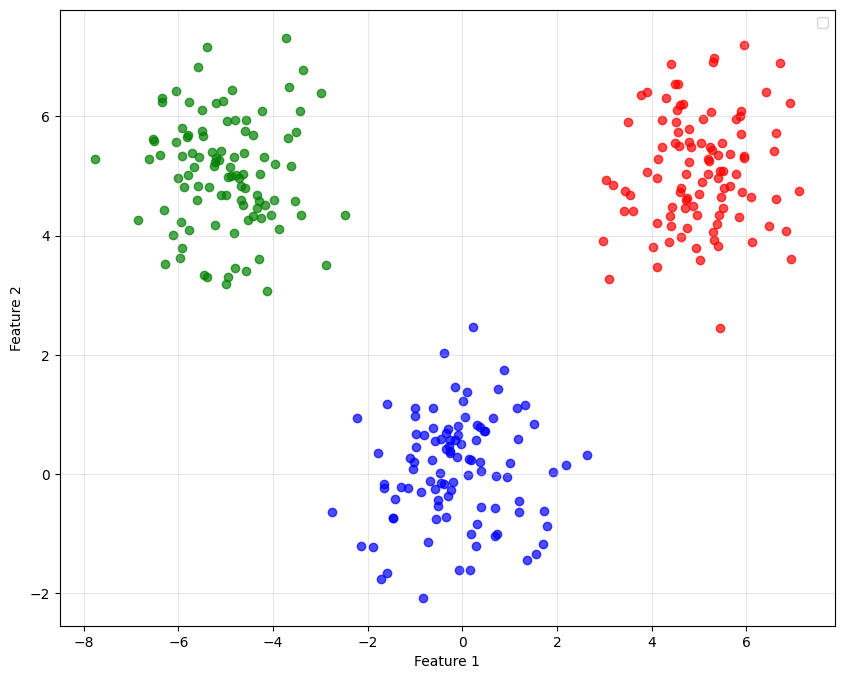

In [ ]:
n_samples = 300
d = 2
centers = np.array([[0, 0], [5, 5], [-5, 5]])
data = []
for center in centers:
    data.append(np.random.multivariate_normal(center, np.eye(d), size=n_samples//3))
data = np.vstack(data)

true_labels = np.zeros(n_samples, dtype=int)
true_labels[n_samples//3:2*n_samples//3] = 1
true_labels[2*n_samples//3:] = 2

plt.figure(figsize=(10, 8))
colors = ['blue', 'red', 'green']

for i in range(3):
    plt.scatter(
        data[true_labels == i, 0], 
        data[true_labels == i, 1], 
        c=colors[i], 
        alpha=0.7
    )

plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.grid(True, alpha=0.3)

plt.savefig('./example/data_plot.png')

plt.show()

In [3]:
print("Fitting DPMM...")
dpmm = DirichletProcessMixtureModel(data)
dpmm.run()

Fitting DPMM...


DPMM Sampling:   0%|          | 0/300 [00:00<?, ?it/s]

DPMM Sampling: 100%|██████████| 300/300 [00:36<00:00,  8.32it/s]


In [4]:
print(f"Number of clusters discovered: {dpmm.n_clusters}")
print(f"Cluster counts: {dict(dpmm.cluster_counts)}")

purity = compute_cluster_purity(true_labels, dpmm.cluster_assignments)
print(f"Clustering purity: {purity:.4f}")

Number of clusters discovered: 3
Cluster counts: {np.int64(42): 100, np.int64(192): 100, np.int64(216): 100}
Clustering purity: 1.0000


### Visualizing the Clustering Results

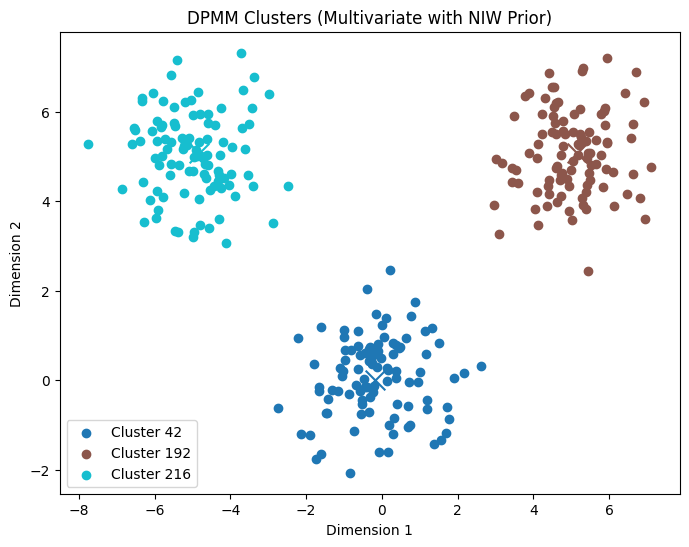

In [ ]:
# Plot the discovered clusters
dpmm.plot_clusters()
plt.save('./example/clusters.png')
plt.show()

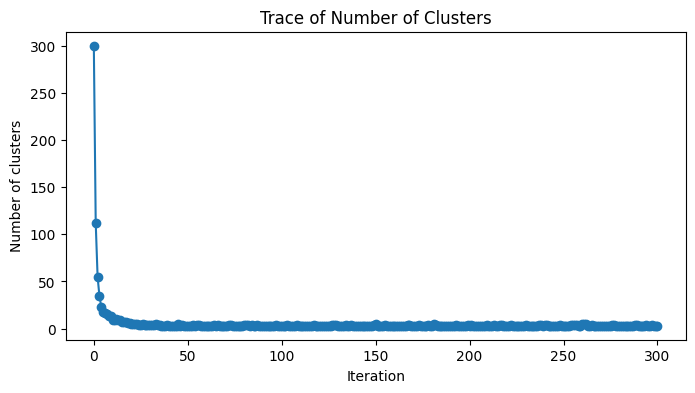

In [ ]:
# Plot the posterior trace of the number of clusters
dpmm.plot_trace()
plt.savefig('./example/posterior_trace.png')
plt.show()

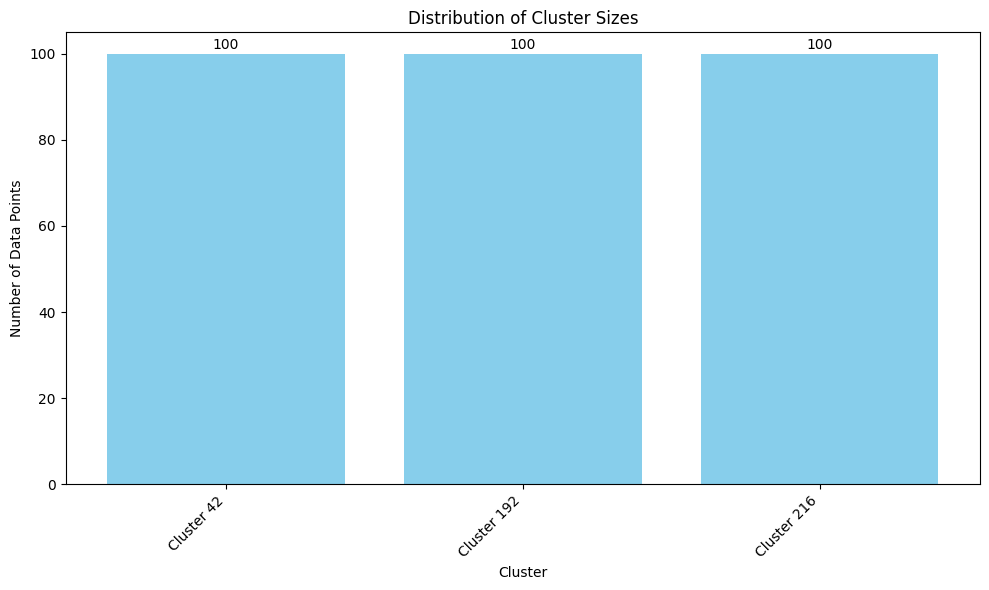

In [ ]:
# Plot the distribution of cluster sizes
dpmm.plot_cluster_sizes()
plt.savefig('./example/cluster_sizes.png')
plt.show()

### Predicting Cluster Assignments for New Data

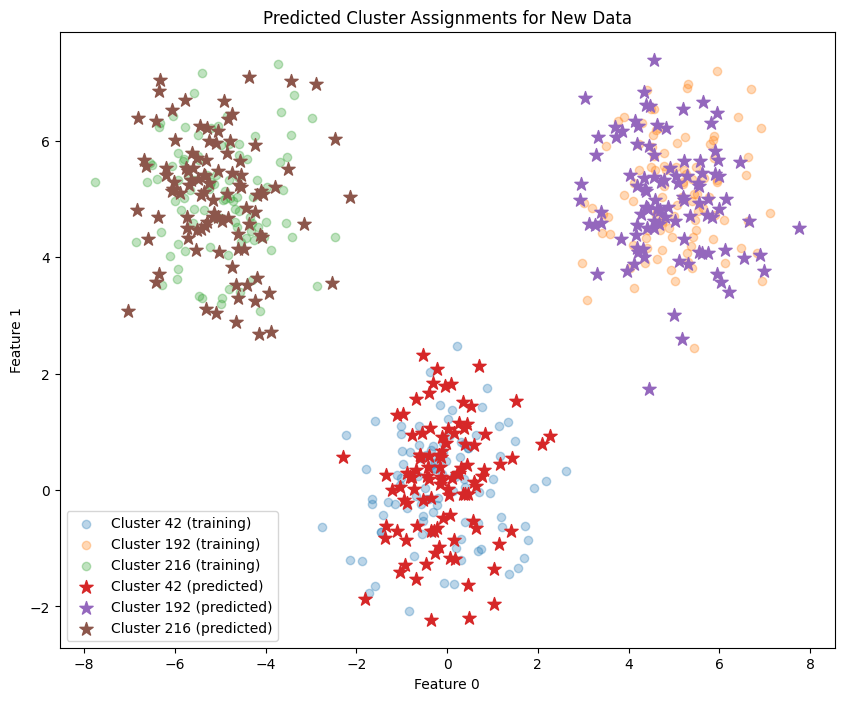

In [ ]:
# Generate new data points
np.random.seed(411)
data_ = []
for center in centers:
    data_.append(np.random.multivariate_normal(center, np.eye(d), size=n_samples//3))
data_ = np.vstack(data_)

pred_labels = dpmm.predict(data_)

# Visualize predictions
plt.figure(figsize=(10, 8))

for cluster in np.unique(dpmm.cluster_assignments):
    mask = dpmm.cluster_assignments == cluster
    plt.scatter(data[mask, 0], data[mask, 1], alpha=0.3, label=f'Cluster {cluster} (training)')

for cluster in np.unique(pred_labels):
    if cluster == -1:  # New cluster
        plt.scatter(data_[pred_labels == cluster, 0], data_[pred_labels == cluster, 1], 
                    marker='x', s=100, c='k', label='New cluster')
    else:
        mask = pred_labels == cluster
        plt.scatter(data_[mask, 0], data_[mask, 1], marker='*', s=100, 
                    label=f'Cluster {cluster} (predicted)')

plt.xlabel('Feature 0')
plt.ylabel('Feature 1')
plt.title('Predicted Cluster Assignments for New Data')
plt.legend()

plt.savefig('./example/predictions.png')

plt.show()

### Effect of the Concentration Parameter $\alpha$

Fitting DPMM with alpha=0.01...


DPMM Sampling: 100%|██████████| 300/300 [00:33<00:00,  8.87it/s]


Fitting DPMM with alpha=1.0...


DPMM Sampling: 100%|██████████| 300/300 [00:36<00:00,  8.25it/s]


Fitting DPMM with alpha=100.0...


DPMM Sampling: 100%|██████████| 300/300 [01:42<00:00,  2.93it/s]


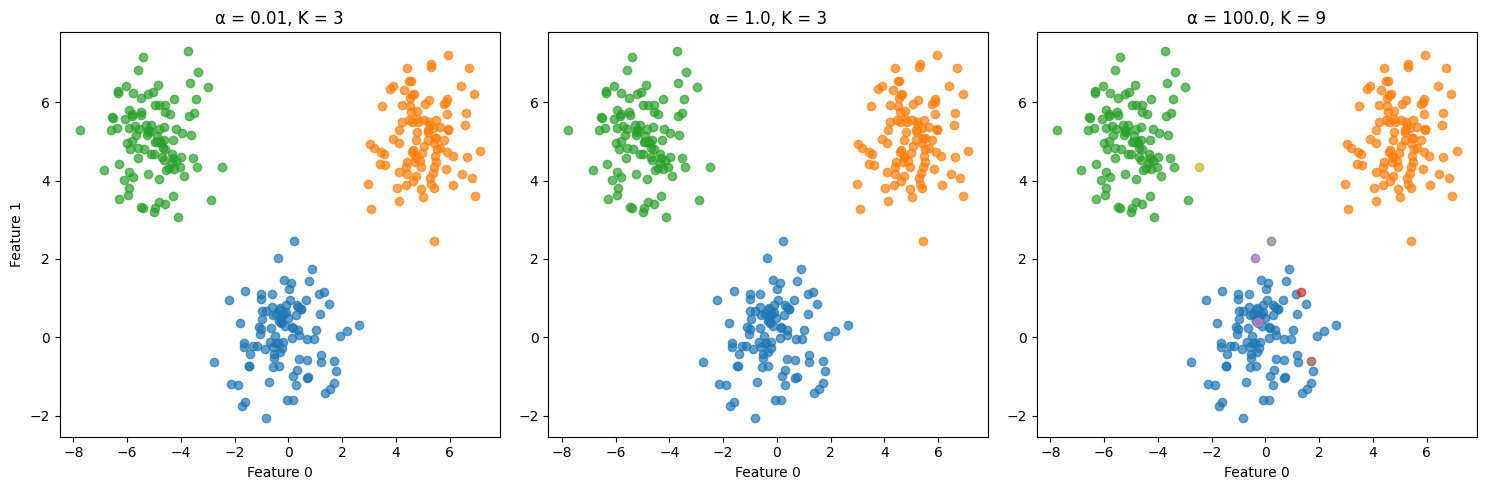

In [10]:
# Function to fit DPMM with different alpha values and plot results
def compare_alpha_values(X, alphas=[0.01, 1.0, 100.0]):
    fig, axes = plt.subplots(1, len(alphas), figsize=(15, 5))
    
    for i, alpha in enumerate(alphas):
        print(f"Fitting DPMM with alpha={alpha}...")
        model = DirichletProcessMixtureModel(data, alpha=alpha)
        model.run()
        
        # Plot clusters
        ax = axes[i]
        for cluster in np.unique(model.cluster_assignments):
            mask = model.cluster_assignments == cluster
            ax.scatter(X[mask, 0], X[mask, 1], alpha=0.7)
        
        ax.set_title(f'α = {alpha}, K = {len(model.cluster_counts)}')
        ax.set_xlabel('Feature 0')
        if i == 0:
            ax.set_ylabel('Feature 1')
    
    plt.tight_layout()
    return fig

compare_alpha_values(data)
plt.show()

## Advantages and Limitations of DPMMs

### Advantages:

1. **Automatic determination of the number of clusters**: DPMMs do not take cluster number as a hypoerparameter, they instead infer this from the data.

2. **Uncertainty quantification**: Being a Bayesian model, DPMMs provide a distribution over possible clusterings, allowing for uncertainty assessment.

3. **Incremental learning**: New data points can be incorporated without retraining the entire model.

### Limitations:

1. **Computational complexity**: MCMC inference can be computationally intensive, especially for large datasets.

2. **Sensitivity to hyperparameters**: The choice of concentration parameter $\alpha$ and base distribution $p_0$ can significantly affect the results.

3. **Interpretability**: DPMM is probabilistic model that can make interpretation more challenging compared to deterministic clustering methods like k-means clustering.

## Sources

https://en.wikipedia.org/wiki/Dirichlet_process

https://andrewcharlesjones.github.io/journal/dpmm.html

https://compcogsci-3016.djnavarro.net/technote_chineserestaurantprocesses.pdf

https://stats.stackexchange.com/questions/68929/can-someone-give-a-simple-guide-of-dirichlet-process-clustering